# <span style="color:red"> Logistic Regression: Re-run with new train/test split</span>

* As the initial train/test split was performed on a random shuffle of all the chunks of text available there is the risk that the model is learning something of the style of the books themselves rather than the translator's. 
* The ideal solution would be to have the same text translated by each of the three translators. In the case of Haruki Murakami there is generally only one English language version of each of his novels available.  Fortunately one of his novels, 'Norwegian Wood' was first translated into English by Alfred Birnbaum for the Japanese market before being re-translated by Jay Rubin for the foreign market. I have the complete Rubin version and a few chapters of the Birnbaum version. Also the first chapter of 'A Wind-up Bird Chronicle' which was translated by Jay Rubin is also available as a short story in the collection 'The Elephant Vanishes', this time translated by Alfred Birnbaum.
* This notebook will therefore use these texts, which have the same Japanese source and two different translators, as the test set and train the model on the remaining texts. If the model is successful at predicting the translator We should therefore generate a model which is only differentiating on the translators style and not the theme or content of the books which is identical.
* Test set 'Norwegian Wood' and 'Wind Up Bird Chronicle Chapter 1'

In [296]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textacy
import re
import pickle
import os

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import label_binarize

import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# extend limit of number of rows and columns to display in cell
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### Load the dataframe containing text chunks and related variables

In [297]:
in_full_path = '../../../Documents/murakami/pkl3/df_all_v02.pkl'
# read back pickle
with open (in_full_path, 'rb') as fp:
    df = pickle.load(fp)

### Check the dataframe is as expected

In [298]:
df.head(1)

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count,...,even_adv,very_adv,again_adv,maybe_adv,as_adv,there_adv,why_adv,really_adv,now_adv,only_adv,when_adv,too_adv,all_adv,just_adv,here_adv,back_adv,never_adv,more_adv,so_adv,always_adv,then_adv,bad_adj,strange_adj,good_adj,own_adj,hard_adj,new_adj,next_adj,real_adj,small_adj,whole_adj,few_adj,able_adj,young_adj,only_adj,much_adj,same_adj,other_adj,old_adj,little_adj,more_adj,right_adj,long_adj,last_adj,different_adj,deep_adj,first_adj,sure_adj,big_adj,vlong_words_count
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.59322,18.008475,-0.4798,0.075,0.862,0.064,18.0,20.0,31.0,9.0,2.0,33.0,51.0,19.0,6.0,3.0,5.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [299]:
df.shape

(5212, 142)

In [300]:
df.book_title.unique()

array(['A Wild Sheep Chase', 'Kafka On The Shore',
       'Colorless Tsukuru Tazaki', 'The Elephant Vanishes',
       'The Wind Up Bird Chronicle', 'Norwegian Wood',
       'Dance Dance Dance'], dtype=object)

In [301]:
# df = df[~df['book_title'].isin(['Kafka On The Shore', 'Colorless Tsukuru Tazaki'])]

In [302]:
df.book_title.unique()

array(['A Wild Sheep Chase', 'Kafka On The Shore',
       'Colorless Tsukuru Tazaki', 'The Elephant Vanishes',
       'The Wind Up Bird Chronicle', 'Norwegian Wood',
       'Dance Dance Dance'], dtype=object)

In [303]:
df.columns

Index(['book_chunk_no', 'number', 'title', 'text', 'fstop_indices',
       'split_indices', 'chunks', 'translator', 'book_title', 'parsed',
       ...
       'more_adj', 'right_adj', 'long_adj', 'last_adj', 'different_adj',
       'deep_adj', 'first_adj', 'sure_adj', 'big_adj', 'vlong_words_count'],
      dtype='object', length=142)

### Set initial Predictor Variables
* Choose normalised count variables from textacy, ntlk dropping some suspicious ones
* not using vader sentiment scores

### Choose features to include in modelling

In [304]:
def feature_select(basic_counts=True, vader=False, pos_counts=False, 
                   words=False, adv=False, adj=False):
    '''create column list depending on features to include in the modelling'''
    columns = []
    if basic_counts:
        columns += [i for i in df.columns if i.startswith('n_') & i.endswith('_norm')]
    if vader:
        columns += [i for i in df.columns if i.startswith('vader_')]
    if pos_counts:
        columns += [i for i in df.columns if i.endswith('_count_norm')]
    if words:
        columns += [i for i in df.columns if i.endswith('_w')]
    if adj:
        columns += [i for i in df.columns if i.endswith('_adj')]
    if adv:
        columns += [i for i in df.columns if i.endswith('_adv')]
    return columns

In [305]:
predictor_cols = feature_select(basic_counts=True, vader=False, pos_counts=True, 
                   words=True, adv=True, adj=True)

### Drop some columns which may be linked to page formatting

In [306]:
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']

In [307]:
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

In [308]:
# predictor_cols

### Set Target and Predictor variables

In [309]:
X = df[predictor_cols]
y = df['trans_code']

### Make Train Test Split with Test as both versions of Norwegian Wood and WUBC chapter 1

In [310]:
df['book_title'].unique()

array(['A Wild Sheep Chase', 'Kafka On The Shore',
       'Colorless Tsukuru Tazaki', 'The Elephant Vanishes',
       'The Wind Up Bird Chronicle', 'Norwegian Wood',
       'Dance Dance Dance'], dtype=object)

In [311]:
# df[(df['book_title'] == 'Norwegian Wood') & (df['translator'] == 'Jay Rubin')] \
#                 [['number', 'translator']].describe()

In [312]:
# df[(df['book_title'] == 'Norwegian Wood') & (df['translator'] == 'Alfred Birnbaum')] \
#                 [['chunks', 'book_chunk_no', 'translator']].head()

In [313]:
df[(df['book_title'] == 'Norwegian Wood') & (df['translator'] == 'Alfred Birnbaum')] \
            ['chunks'].iloc[0]

'The scene at dinner was pretty much the same as the evening before-same faces and talk and at\xadmosphere. Only the menu had changed. The lab\xadcoated man who had talked about stomach secretions under weightless conditions joined our table and told us about brain size in correlation to its abilities. He told us about the brain capacities of Napoleon and Bismarck while we ate something called soyburger steak. He pushed his plate aside and, pulling out a notepad, began to draw a diagram of the brain in ballpoint. "No, that’s not quite right," he’d say, then start over. When he finally finished the drawing to his satisfaction, he returned the notepad to a pocket of his lab coat and slipped the pen into his breast pocket. That made three ballpoint pens, a pencil, and a ruler in his breast pocket. "Winter’s great here, I tell you. You simply must come next winter," he said as he left, same as yesterday. "Is he a doctor or a patient?" was all I could think to ask Reiko.'

In [314]:
def check_word(x):
    if 'Napoleon' in x:
        return x
    
df[(df['book_title'] == 'Norwegian Wood') & (df['translator'] == 'Jay Rubin')] \
            ['chunks'].apply(lambda x: check_word(x)).dropna().iloc[0]

'"Tell me all about his, uh, you know, later." "We didn’t do any of that," said Naoko, reddening. "Really?" Reiko asked me. "Nothing?" "Nothing," I said. "Bo-o-o-ring!" she said with a bored look on her face. "True," I said, sipping my coffee. The scene in the dining hall was the same as the day before - the mood, the voices, the faces. Only the menu had changed. The balding man in white, who yesterday had been talking about the secretion of gastric juices under weightless conditions, joined the three of us at our table and talked for a long time about the correlation of brain size to intelligence. As we ate our soybean burgers, we heard all about the volume of Bismarck’s brain and Napoleon’s. He pushed his plate aside and used a ballpoint pen and notepaper to draw sketches of brains. He would start to draw, declare "No, that’s not quite it", and begin a new one. This happened several times.'

In [315]:
def check_word(x):
    if 'Napoleon' in x:
        return True
    
df_temp = df.copy()
df_temp['napoleon'] = df[(df['book_title'] == 'Norwegian Wood') & (df['translator'] == 'Jay Rubin')] \
            ['chunks'].apply(lambda x: check_word(x))

In [316]:
df_temp[df_temp['napoleon'] == True]

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count,...,very_adv,again_adv,maybe_adv,as_adv,there_adv,why_adv,really_adv,now_adv,only_adv,when_adv,too_adv,all_adv,just_adv,here_adv,back_adv,never_adv,more_adv,so_adv,always_adv,then_adv,bad_adj,strange_adj,good_adj,own_adj,hard_adj,new_adj,next_adj,real_adj,small_adj,whole_adj,few_adj,able_adj,young_adj,only_adj,much_adj,same_adj,other_adj,old_adj,little_adj,more_adj,right_adj,long_adj,last_adj,different_adj,deep_adj,first_adj,sure_adj,big_adj,vlong_words_count,napoleon
3996,321,2,Book 2,"m\n \nsf Thanks for your letter,\n wrote Naoko...","[43, 88, 213, 296, 343, 376, 480, 632, 695, 74...","[924, 1926, 2925, 3997, 4861, 5754, 6924, 7914...","""Tell me all about his, uh, you know, later."" ...",Jay Rubin,Norwegian Wood,"("", Tell, me, all, about, his, ,, uh, ,, you, ...",18,168,690,212,118,24,135,9,1,903,19.933555,186.046512,764.119601,234.772979,130.675526,26.578073,149.501661,9.966777,0.6654,0.013,0.948,0.039,16.0,25.0,28.0,9.0,2.0,53.0,36.0,20.0,5.0,2.0,6.0,6.0,5.0,5.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,True


In [317]:
df['test_flag'] = 0

In [318]:
df['test_flag'] = df.apply(
    lambda row: 1 if row['book_title'] == 'Norwegian Wood' 
                    and row['translator'] == 'Jay Rubin' 
                    and row['book_chunk_no'] >= 321 
                    else row['test_flag'],
    axis=1
)

In [319]:
df['test_flag'] = df.apply(
    lambda row: 1 if row['book_title'] == 'Norwegian Wood' 
                    and row['translator'] == 'Alfred Birnbaum' 
                    else row['test_flag'],
    axis=1
)

In [320]:
df['test_flag'] = df.apply(
    lambda row: 1 if row['book_title'] == 'The Wind Up Bird Chronicle' 
                    and row['number'] == '1' 
                    and row['book_chunk_no'] < 60
                    else row['test_flag'],
    axis=1
)

In [321]:
df['test_flag'] = df.apply(
    lambda row: 1 if row['book_title'] == 'The Elephant Vanishes' 
                    and row['number'] == 1 
                    else row['test_flag'],
    axis=1
)

In [322]:
df['test_flag'].sum()

700

In [323]:
indices = list(df.index)

In [324]:
X_train = X[df['test_flag'] == 0]
y_train = y[df['test_flag'] == 0]
X_test = X[df['test_flag'] == 1]
y_test = y[df['test_flag'] == 1]
indices_train = [x for x, y in zip(indices, df['test_flag'] == 0) if y]
indices_test = [x for x, y in zip(indices, df['test_flag'] == 1) if y]

In [325]:
baseline_acc = y_test.value_counts(normalize=True).max()
baseline_acc

0.5042857142857143

In [326]:
X_test.tail()

,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,pron_count_norm,verb_count_norm,det_count_norm,adj_count_norm,noun_count_norm,adp_count_norm,cconj_count_norm,sconj_count_norm,adv_count_norm,aux_count_norm,part_count_norm,propn_count_norm,intj_count_norm,the_w,to_w,and_w,of_w,you_w,was_w,he_w,she_w,had_w,said_w,like_w,just_w,time_w,know_w,think_w,got_w,right_w,bad_adj,strange_adj,good_adj,own_adj,hard_adj,new_adj,next_adj,real_adj,small_adj,whole_adj,few_adj,able_adj,young_adj,only_adj,much_adj,same_adj,other_adj,old_adj,little_adj,more_adj,right_adj,long_adj,last_adj,different_adj,deep_adj,first_adj,sure_adj,big_adj,how_adv,still_adv,where_adv,even_adv,very_adv,again_adv,maybe_adv,as_adv,there_adv,why_adv,really_adv,now_adv,only_adv,when_adv,too_adv,all_adv,just_adv,here_adv,back_adv,never_adv,more_adv,so_adv,always_adv,then_adv
5248,19.269777,196.754564,758.620690,240.365112,117.647059,25.354970,161.257606,7.099391,25.354970,36.511156,30.425963,10.141988,31.440162,19.269777,5.070994,4.056795,15.212982,5.070994,3.042596,6.085193,2.028398,2,3,4,3,3,1,0,1,0,2,4,2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,2,0,0,0,0,1,0,2
5249,32.289628,195.694716,746.575342,234.833659,110.567515,20.547945,163.405088,4.892368,40.117417,46.966732,13.698630,7.827789,14.677104,21.526419,2.935421,1.956947,20.547945,8.806262,6.849315,5.870841,2.935421,2,3,3,1,6,3,0,1,0,5,0,0,0,0,4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,4,0,0,0,2,0,0,0,2,1,0,0,0,0,0,0,1,1,1
5250,21.671827,191.950464,769.865841,234.262126,127.966976,21.671827,157.894737,8.255934,27.863777,41.279670,18.575851,11.351909,24.767802,21.671827,7.223942,7.223942,16.511868,3.095975,2.063983,5.159959,1.031992,2,2,6,2,1,1,0,3,0,4,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
5251,26.418787,196.673190,763.209393,239.726027,121.330724,22.504892,158.512720,3.913894,36.203523,47.945205,17.612524,8.806262,21.526419,8.806262,5.870841,2.935421,16.634051,8.806262,7.827789,10.763209,1.956947,6,9,5,1,7,0,0,4,0,3,3,0,0,0,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,2,0,1,0,1,2,1,0,0,0,0,0,0,3,1,0
5252,29.682702,206.755374,746.161720,242.579324,119.754350,16.376663,176.049130,5.117707,48.106448,40.941658,13.306039,7.164790,16.376663,19.447288,11.258956,2.047083,11.258956,16.376663,9.211873,9.211873,0.000000,6,8,7,4,5,2,0,2,4,4,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2,0,1,0,0,1,0,0,1,0


In [327]:
y_test.tail()

5248    0
5249    0
5250    0
5251    0
5252    0
Name: trans_code, dtype: int64

In [328]:
# X_train = X_train.sample(frac=1, random_state=1)
# y_train = y_train.sample(frac=1, random_state=1)

### Standardise the predictor variables

In [329]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

###  Gridsearch Logistic Regression 

In [330]:
def lr_mc_gridsearch(X_train, y_train):
    # set model
    model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000)
    # set typical grid search parameters
#     params = {'C': np.logspace(-4, 4, 10),
#           'penalty': ['l1', 'l2'],
#           'fit_intercept': [True, False]}
    params = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}

    # instantiate model
    model_gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  return_train_score=True)
    # fit the model
    model_gs.fit(X_train, y_train)
    return model_gs

In [331]:
def lr_gridsearch_score(model, X_train, y_train, X_test, y_test):
    
    # print the grid search results
    results_dict = {}
    print('Best Parameters:')
    print(model.best_params_)
    print('Best estimator mean cross validated training score:')
    print(model.best_score_)
    print('Best estimator score on the full training set:')
    print(model.score(X_train, y_train))
    print('Best estimator score on the test set:')
    print(model.score(X_test, y_test))
#     print('ROC-AUC score on the test set:')
    
#     # store the grid search results as a dictionary
#     y_bin = label_binarize(y_test, model.classes_)
#     for i, class_ in enumerate(model.classes_):
#         print('Class {}:'.format(class_), round(roc_auc_score(y_bin[:,i],model.predict_proba(X_test)[:,i]),2))
    results_dict['Best_Parameters'] = model.best_params_
    results_dict['Best_CV_Score'] = model.best_score_
    results_dict['Best_Train_Score'] = model.score(X_train, y_train)
    results_dict['Best_Test_Score'] = model.score(X_test, y_test)
#     results_dict['AUC_Class_0'] = roc_auc_score(y_bin[:,0],model.predict_proba(X_test)[:,0])
#     results_dict['AUC_Class_1'] = roc_auc_score(y_bin[:,1],model.predict_proba(X_test)[:,1])
#     results_dict['AUC_Class_2'] = roc_auc_score(y_bin[:,2],model.predict_proba(X_test)[:,2])
    predictions = model.predict(X_test)
    results_dict['conmat'] = confusion_matrix(
        y_test, predictions, labels=[0, 1, 2])

    return results_dict

In [332]:
lreg_gs_01 = lr_mc_gridsearch(X_train, y_train)

In [333]:
lreg_gs_01_results = lr_gridsearch_score(lreg_gs_01, X_train, y_train, X_test, y_test)

Best Parameters:
{'C': 0.1, 'penalty': 'l2'}
Best estimator mean cross validated training score:
0.6529361355226357
Best estimator score on the full training set:
0.7154255319148937
Best estimator score on the test set:
0.58


In [334]:
lreg_gs_01_results

{'Best_Parameters': {'C': 0.1, 'penalty': 'l2'},
 'Best_CV_Score': 0.6529361355226357,
 'Best_Train_Score': 0.7154255319148937,
 'Best_Test_Score': 0.58,
 'conmat': array([[192,  83,  72],
        [ 94, 214,  45],
        [  0,   0,   0]])}

In [225]:
# y_test.value_counts(normalize=True)

In [335]:
baseline_acc = y_test.value_counts(normalize=True).max()
baseline_acc

0.5042857142857143

In [336]:
predictions = lreg_gs_01.predict(X_test)
conmat = confusion_matrix(
        y_test, predictions, labels=[0, 1, 2])
print(pd.DataFrame(conmat, index=['actual birnbaum', 'actual rubin', 'actual gabriel'],
                             columns=['predicted birnbaum', 'predicted rubin', 'predicted gabriel']))

                 predicted birnbaum  predicted rubin  predicted gabriel
actual birnbaum                 192               83                 72
actual rubin                     94              214                 45
actual gabriel                    0                0                  0


In [337]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.67      0.55      0.61       347
           1       0.72      0.61      0.66       353
           2       0.00      0.00      0.00         0

    accuracy                           0.58       700
   macro avg       0.46      0.39      0.42       700
weighted avg       0.70      0.58      0.63       700



/Users/Steven/opt/anaconda3/envs/textacy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### There is a very slight improvement over the basic logistic regression - optimizing parameters with gridsearch does not improve accuracy significantly

### Save the model

In [25]:
# # set the output path and name
# out_path = '../../../Documents/murakami/pkl_models/'
# out_name = 'lreg_gs_01_ns'
# out_full_path = out_path + out_name + '.pkl'

# # save pickle
# with open(out_full_path, 'wb') as fp:
#     pickle.dump(lreg_gs_01, fp)

## Review most confidently predicted texts per translator

In [338]:
# Get the predicted probabilities and explicitly name the columns:
Y_pp = pd.DataFrame(lreg_gs_01.predict_proba(X_test), 
             columns=['trans_0_pp', 'trans_1_pp', 'trans_2_pp'])
# add the original indices from before the train test shuffle
Y_pp['original_index'] = indices_test
Y_pp.head()

,trans_0_pp,trans_1_pp,trans_2_pp,original_index
0,0.113802,0.197982,0.688216,1878
1,0.295786,0.168162,0.536052,1879
2,0.525187,0.195341,0.279472,1880
3,0.780780,0.204005,0.015215,1881
4,0.508686,0.402482,0.088833,1882


In [229]:
# Y_pp_merged = Y_pp.join(df, how='left')

In [339]:
Y_pp_merged = Y_pp.merge(df, how='left', left_on='original_index', right_index=True)
# Y_pp_merged = Y_pp.merge(df, how='left', left_index=True, right_index=True)

In [340]:
len(Y_pp_merged)

700

In [341]:
Y_pp_merged.head()

,trans_0_pp,trans_1_pp,trans_2_pp,original_index,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,...,very_adv,again_adv,maybe_adv,as_adv,there_adv,why_adv,really_adv,now_adv,only_adv,when_adv,too_adv,all_adv,just_adv,here_adv,back_adv,never_adv,more_adv,so_adv,always_adv,then_adv,bad_adj,strange_adj,good_adj,own_adj,hard_adj,new_adj,next_adj,real_adj,small_adj,whole_adj,few_adj,able_adj,young_adj,only_adj,much_adj,same_adj,other_adj,old_adj,little_adj,more_adj,right_adj,long_adj,last_adj,different_adj,deep_adj,first_adj,sure_adj,big_adj,vlong_words_count,test_flag
0,0.113802,0.197982,0.688216,1878,0,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...",I’M IN THEkitchen cooking spaghetti when the w...,Alfred Birnbaum,The Elephant Vanishes,"(I’M, IN, THEkitchen, cooking, spaghetti, when...",14,166,731,230,109,33,112,8,0,929,15.069968,178.686760,786.867600,247.578041,117.330463,35.522067,120.559742,8.611410,0.8903,0.037,0.862,0.102,16.0,32.0,24.0,3.0,2.0,38.0,34.0,18.0,4.0,1.0,15.0,5.0,2.0,10.0,...,0,1,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,0.295786,0.168162,0.536052,1879,1,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...",And I pride myself on a near-perfect ear for v...,Alfred Birnbaum,The Elephant Vanishes,"(And, I, pride, myself, on, a, near, -, perfec...",25,206,814,262,123,30,161,9,0,1057,23.651845,194.891202,770.104068,247.871334,116.367077,28.382214,152.317881,8.514664,0.7800,0.040,0.872,0.088,27.0,36.0,25.0,14.0,7.0,53.0,35.0,22.0,7.0,2.0,13.0,11.0,6.0,1.0,...,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
2,0.525187,0.195341,0.279472,1880,2,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...","“I hardly had any breakfast, so I was getting ...",Alfred Birnbaum,The Elephant Vanishes,"(“, I, hardly, had, any, breakfast, ,, so, I, ...",20,178,711,224,117,29,142,10,0,936,21.367521,190.170940,759.615385,239.316239,125.000000,30.982906,151.709402,10.683761,-0.8738,0.073,0.909,0.018,28.0,36.0,22.0,11.0,1.0,56.0,20.0,15.0,5.0,3.0,20.0,9.0,5.0,0.0,...,0,0,0,1,0,0,0,3,0,2,1,0,1,0,0,0,0,3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.780780,0.204005,0.015215,1881,3,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...",I stare blankly at the receiver in my hand and...,Alfred Birnbaum,The Elephant Vanishes,"(I, stare, blankly, at, the, receiver, in, my,...",13,197,803,254,129,30,149,7,0,1018,12.770138,193.516699,788.801572,249.508841,126.719057,29.469548,146.365422,6.876228,0.9094,0.014,0.909,0.077,22.0,33.0,27.0,6.0,3.0,26.0,45.0,28.0,7.0,4.0,12.0,7.0,3.0,0.0,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0.508686,0.402482,0.088833,1882,4,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...","What the hell, I tell myself, what do I care a...",Alfred Birnbaum,The Elephant Vanishes,"(What, the, hell, ,, I, tell, myself

In [343]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_0_pp', ascending=False).head(5)

,trans_0_pp,trans_1_pp,trans_2_pp,chunks,translator,book_title,book_chunk_no,number
555,0.891758,0.098252,0.009990,"They buy the sake, order the sushi, do the con...",Alfred Birnbaum,Norwegian Wood,151,9
58,0.881250,0.062562,0.056188,Had the women of the world chosen today to su...,Jay Rubin,The Wind Up Bird Chronicle,6,1
64,0.877488,0.110920,0.011592,“Are you sure you know me?” “Of course I do. ...,Jay Rubin,The Wind Up Bird Chronicle,12,1
40,0.875933,0.065962,0.058105,“Even if there’s the possibility of passing i...,Alfred Birnbaum,The Elephant Vanishes,41,1
548,0.875102,0.105540,0.019358,"""Are you really so stuck on Nagasawa?"" ""I real...",Alfred Birnbaum,Norwegian Wood,144,8


In [344]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_1_pp', ascending=False).head(5)

,trans_0_pp,trans_1_pp,trans_2_pp,chunks,translator,book_title,book_chunk_no,number
121,0.008673,0.989478,0.001849,They said that I had snipped the clothes off m...,Jay Rubin,Norwegian Wood,348,2
349,0.017321,0.980136,0.002543,"After saying goodbye to Midori, I bought a new...",Jay Rubin,Norwegian Wood,576,2
385,0.003921,0.978964,0.017116,"Oh, Reiko, it was so wonderful! Now it felt as...",Jay Rubin,Norwegian Wood,612,2
72,0.011389,0.968339,0.020271,"The screen of the kennel door bulged outward,...",Jay Rubin,The Wind Up Bird Chronicle,20,1
308,0.021081,0.962914,0.016005,"I did my laundry for the first time in weeks, ...",Jay Rubin,Norwegian Wood,535,2


In [345]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_2_pp', ascending=False).head(5)

,trans_0_pp,trans_1_pp,trans_2_pp,chunks,translator,book_title,book_chunk_no,number
520,0.051152,0.017353,0.931495,How come these simpletons don’t make an effort...,Alfred Birnbaum,Norwegian Wood,115,8
338,0.023803,0.081820,0.894377,"""How can you be such an idiot? Of course I wa...",Jay Rubin,Norwegian Wood,565,2
240,0.024707,0.097960,0.877334,You seem like someone who could be happy with ...,Jay Rubin,Norwegian Wood,467,2
689,0.045532,0.083115,0.871353,"After all, you’d already made your decision be...",Alfred Birnbaum,Norwegian Wood,285,11
213,0.087056,0.046956,0.865988,They’re working their fingers to the bone. Or ...,Jay Rubin,Norwegian Wood,440,2


## Most confident for translator 0: 
* better now without 'A wild sheep chase' with the strange dialogue!

In [346]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_0_pp', ascending=False).iloc[0,3]

'They buy the sake, order the sushi, do the consoling and the crying, raise a fuss, divvy up the keepsakes. It’s easy. A picnic compared to visiting the hospital day in and day out, a real picnic. We were so exhausted, my sister and me, no tears would even come. Honest. It was enough to make others see us as cold. Still, we refused to cry, out of spite almost. Sure, we could have cried false tears, but no way were we about to put on a show for anyone. Everyone expecting us to cry only made us want to do the opposite. My sister and I are alike in that way, though otherwise we’re totally different." Midori’s bracelets rattled as she summoned a waiter to order another Tom Collins and pis\xadtachios. "Once everyone had gone home, we stayed up drinking sake until dawn, a whole big bottle of it. We bad-mouthed the lot of them, the funeral crowd. So-and-so was a real idiot, this guy a jerk. Mangy dogs, pigs, hypocrites, common crooks. The whole night through. We got it out of our systems and 

In [347]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_0_pp', ascending=False).iloc[1,3]

' Had the women of the world chosen today to surprise me on the telephone? “My benefit’s going to run out sooner or later. I can’t keep hanging around forever.” “True, but with my raise and occasional jobs on the side and our savings, we can get by OK if we’re careful. There’s no real emergency. Do you hate staying at home like this and doing housework? I mean, is this life so wrong for you?” “I don’t know,” I answered honestly. I really didn’t know. “Well, take your time and have a think,” she said. “Anyhow, has the cat come back?” The cat. I hadn’t thought about the cat all morning. “No,” I said. “Not yet.” “Can you please have a look around the neighbourhood? It’s been gone over a week now.” I gave a noncommittal grunt and shifted the receiver back to my left hand. She went on: “I’m almost certain it’s hanging around the empty house at the other end of the alley. The one with the bird statue in the yard. I have often seen it there.” “The alley? Since when have you been going to the 

In [348]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_0_pp', ascending=False).iloc[2,3]

' “Are you sure you know me?” “Of course I do. We’ve met hundreds of times.” “Where? When?” “Somewhere, sometime,” she said. “But if I went into that, ten minutes would never be enough. What’s important is the time we have now. The present. Don’t you agree?” “Maybe. But I’d like some proof that you know me.” “What kind of proof?” “My age, say?” “Thirty,” she answered at once. “Thirty and two months. Good enough?” That shut me up. Obviously she did know me, but her voice meant nothing to me at all. “Now it’s your turn,” she said, her voice seductive. “Try picturing me. From my voice. Imagine what I’m like. My age. Where I am. How I’m dressed. Go ahead.” “I have no idea,” I said. “Oh, come on,” she said. “Try.” I looked at my watch. Only a minute and five seconds gone. “I have no idea,” I said again. “Then let me help you,” she said. “I’m in bed. I’ve just come out of the shower, and I’m not wearing a thing.” Oh, great. Telephone sex.'

## Most confident for translator 1

In [349]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_1_pp', ascending=False).iloc[0,3]

'They said that I had snipped the clothes off my piano pupil and tried to do things to her and when she had resisted I had slapped her so hard her face swelled up. They had turned the story on its head, of course, which was bad enough, but what really shocked me was that people knew I had been hospitalized. "My friend said she was telling everyone that she had known me for ever and that I was not like that, but the girl’s parents believed her version and were spreading it around the neighbourhood. In addition, they had investigated my background and found that I had a history of mental problems. "The way my friend heard it, the girl had come home from her lesson one day - that day, of course - with her face all bloated, her lip split and bloody, buttons missing from her blouse, and even her underwear tom. Can you believe it? She had done all this to back up her story, of course, which her mother had to drag out of her.'

In [350]:
# import re
# test_txt_2 = re.sub("\'","’",test_txt)
# test_txt_2


In [351]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_1_pp', ascending=False).iloc[1,3]

'After saying goodbye to Midori, I bought a newspaper at the station, but when I opened it on the train, I realized I had absolutely no desire to read a paper and in fact couldn’t understand what it said. All I could do was glare at the incomprehensible page of print and wonder what was going to happen to me from now on, and how the things around me would be changing. I felt as if the world was pulsating every now and then. I sighed deeply and closed my eyes. As regards what I had done that day, I felt not the slightest regret; I knew for certain that if I had to do it all over again, I would live this day in exactly the same way. I would hold Midori tight on the roof in the rain; I would get soaking wet with her; and I would let her fingers bring me to climax in her bed. I had no doubts about those things. I loved Midori, and I was happy that she had come back to me. The two of us could make it, that was certain. As Midori herself had said, she was a real, live girl with blood in her 

In [352]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_1_pp', ascending=False).iloc[2,3]

'Oh, Reiko, it was so wonderful! Now it felt as if my brain was just going to melt away. I wanted to stay like that forever, to stay in his arms for the rest of my life. That’s how great it was.’ "So I said to her, "If it was so great, why didn’t you just stay with Watanabe and keep doing it every day?’ But she said, "No. Reiko, I knew it would never happen again. I knew this was something that would come to me once, and leave, and never come back. This would be a once-in-a-lifetime thing. I had never felt anything like it before, and I’ve never felt anything like it since. I’ve never felt that I wanted to do it again, and I’ve never grown wet like that again.’ "Of course, I explained to her that this was something that often happened to young women and that, in most cases, it cures itself with age. And, after all, it had worked that one time: there was no need to worry it wouldn’t happen again. I myself had had all kinds of trouble when I was first married. "But she said. "No, that’s 

## Most confident for translator 2

In [353]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_2_pp', ascending=False).iloc[0,3]

'How come these simpletons don’t make an effort? They don’t make an effort and they complain that things are unfair!" I shot Nagasawa a surprised look. "Correct me if I’m wrong, but from where I sit I sure get the impres\xadsion that people are grinding away like mad. Am I wrong?" "That’s not effort, that’s just labor," Nagasawa spat out. "Not the effort I’m talking about. The ef\xadfort I’m talking about is to go about things with will and purpose." "Like taking up Spanish once you’ve landed a job, when everybody else would just lie back?" "Precisely. I’m going to master Spanish by spring. To add to my English and German and French, plus passable Italian. Can you get this far without making an effort?" He took a drag on his cigarette and I thought of 103 Midori’s father. I don’t think he would even think of studying Spanish from TV. A difference between effort and labor? He’d probably been too busy to even consider that. Busy with work, busy bringing his daughter back from Fukushima.'

In [354]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_2_pp', ascending=False).iloc[1,3]

' "How can you be such an idiot? Of course I wanted to see you! I told you how much I like you! When I like somebody I really like them. It doesn’t turn on and off for me just like that. Don’t you realize at least that much about me?" "Well, sure, but - " "That’s why I was so mad at you! I wanted to give you a good kick up the arse. I mean, we hadn’t seen each other that whole time, and you were so spaced out thinking about this other girl you didn’t even look at me! How could I not get angry at you? But apart from all that, I had been feeling for a long time that it would be better for me if I kept away from you for a while. To get things clear in my head." "What kind of things?" "Our relationship, of course. It was getting to the point where I enjoyed being with you far more than being with him, I mean, don’t you think there’s something weird about that? And difficult? Of course I still like him. He’s a little self-centred and narrow-minded and kind of a fascist, but he’s got a lot o

In [355]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_2_pp', ascending=False).iloc[2,3]

'You seem like someone who could be happy with just about anybody, so how did you end up with Nagasawa of all people?" "Things like that just happen. There’s probably not much you can do about them. It’s certainly true in my case. Of course, Nagasawa would say it’s my responsibility, not his.’ "I’m sure he would." "But anyway, Tom, I’m not the smartest girl in the world. If anything. I’m sort of on the stupid side, and old-fashioned. I couldn’t care less about "systems’ and "responsibility’. All I want is to get married and have a man I love hold me in his arms every night and make babies. That’s plenty for me. It’s all I want out of life." "And what Nagasawa wants out of life has nothing to do with that." "People change, though, don’t you think?" Hatsumi asked. "You mean, like, they go out into society and get a kick up the arse and grow up?" "Yeah. And if he’s away from me for a long time, his feelings for me could change, don’t you think?" "Maybe, if he were an ordinary guy," I said

## Precision-Recall Plot

In [357]:
probabilities = lreg_gs_01.predict_proba(X_test)

In [358]:
def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

ValueError: Found input variables with inconsistent numbers of samples: [1400, 2100]

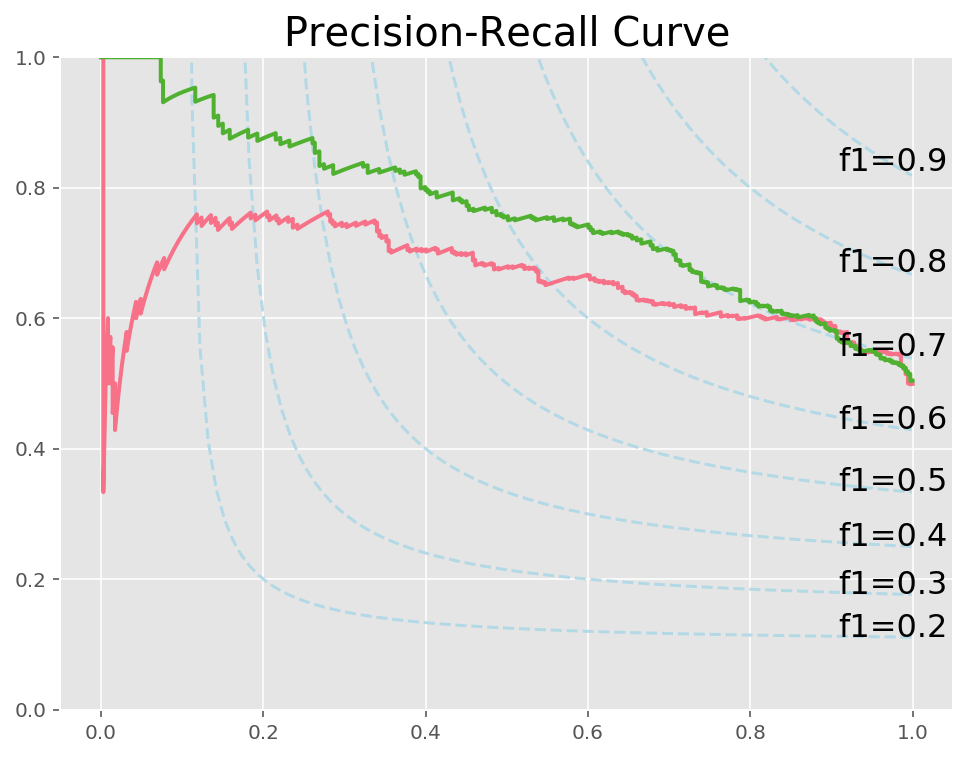

In [359]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

In [213]:
# label binarizer - not sure if needed?
y_bin = label_binarize(y_test, lreg_final.classes_)

In [214]:
print('Area under precision-recall curve:')
for i, class_ in enumerate(lreg_final.classes_):
    print('Class {}:'.format(class_), round(average_precision_score(y_bin[:,i],lreg_final.predict_proba(X_test)[:,i]),4))

Area under precision-recall curve:
Class 0: 0.7305
Class 1: 0.7964
Class 2: 0.6898


## ROC Plot

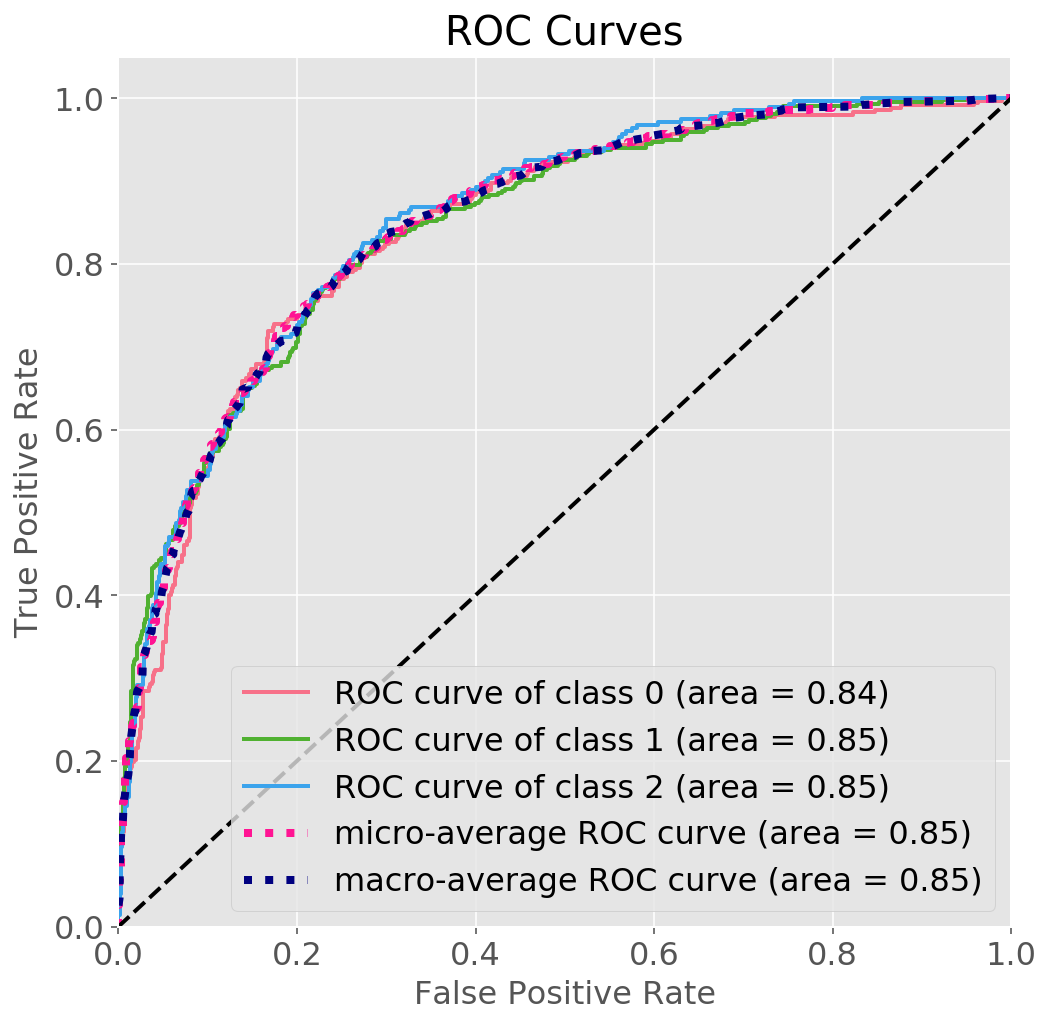

In [215]:
skplt.metrics.plot_roc(y_test, probabilities, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,8), cmap=cmap)
plt.show()

In [216]:
print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(lreg_final.classes_):
    print('Class {}:'.format(class_), round(roc_auc_score(y_bin[:,i],lreg_final.predict_proba(X_test)[:,i]),2))

Area under ROC curve (ROC-AUC):
Class 0: 0.84
Class 1: 0.85
Class 2: 0.85


In [217]:
skplt.metrics.roc_curve(y_test==0, probabilities[:,0])

(array([0.        , 0.        , 0.        , 0.00143062, 0.00143062,
        0.00286123, 0.00286123, 0.00572246, 0.00572246, 0.00715308,
        0.00715308, 0.00858369, 0.00858369, 0.01144492, 0.01144492,
        0.01287554, 0.01287554, 0.01430615, 0.01430615, 0.01573677,
        0.01573677, 0.01716738, 0.01716738, 0.02002861, 0.02002861,
        0.02145923, 0.02145923, 0.02288984, 0.02288984, 0.02432046,
        0.02432046, 0.02575107, 0.02575107, 0.02718169, 0.02718169,
        0.03433476, 0.03433476, 0.03576538, 0.03576538, 0.03719599,
        0.03719599, 0.03862661, 0.03862661, 0.04005722, 0.04005722,
        0.04148784, 0.04148784, 0.0472103 , 0.0472103 , 0.04864092,
        0.04864092, 0.05007153, 0.05007153, 0.05293276, 0.05293276,
        0.05436338, 0.05436338, 0.05579399, 0.05579399, 0.05722461,
        0.05722461, 0.05865522, 0.05865522, 0.06008584, 0.06008584,
        0.06151645, 0.06151645, 0.06294707, 0.06294707, 0.06437768,
        0.06437768, 0.0658083 , 0.0658083 , 0.06